# Type Flavor 
Can we figure out what type a card is based on its flavor text?
We will look at the 6 main card types:
- Creatures
- Lands
- Artifacts
- Enchantments
- Instants
- Sorceries

As we embark on this, there are a few things to consider:
- Several cards will have multiple types. For example, "Artifact Creatures" are rather common.
- Instants and Sorceries differ vary little mechanically, and might thus overlap significantly in flavor text as well.
- Unlike colors, card types are not evenly distributed among cards - there are many more creatures in the game than other types. We will need to adjust how we sample our data to address this.

In [85]:
import datetime, os, requests, time
import numpy as np
import pandas as pd
import CF_standard_functions as cf
import pickle as pkl
from matplotlib import pyplot as plt

### Type distributions
Let's start addressing the last point listed above: how many cards of each type are there? Where to card types overlap? \
First let's get our data:

In [2]:
# Set these directories to determine where to save/load the data from:
savepath = "C:\\Users\\gordo\\Documents\\Python Scripts\\Scryfall Projects\\MtG_ClassyFlavor\\"
filename = 'CardData.pkl'
# Directory for getting data from Scryfall:
sf_bulk_url = "https://api.scryfall.com/bulk-data"

if (os.path.isfile(savepath+filename)) and (cf.file_age_in_hours(savepath+filename) < 24):
    print('Loading card data from file...')
    with open(savepath+filename,'rb') as datafile:
        data = pkl.load(datafile)
    print('Done!')
else:
    data = cf.data_from_scryfall()
    print('Saving data locally...')
    with open(savepath+filename,'wb') as datafile:
        pkl.dump(data,datafile)
    print('Done!')
    
print(f"{data.shape[0]} cards with unique flavor text in data set")

Loading card data from file...
Done!
20593 cards with unique flavor text in data set


#### Parsing type lines
The card types are listed in the _type_line_ column with the format _(Supertype) Type1 (Type2) — (Subtype1) (Subtype2) ..._ \
Every card has at least 1 type with optional subtypes listed after an em-dash. Some cards have supertypes (such as "Legendary" or "Basic") which always precede the card types. \
We will parse through this and add a column named _card_type_ which contains only a string of card types. \
Some cards are also "split" cards - two card objects squeezed on to the same piece of cardboard. These are denoted with two slashes "//" in the type line and name. These are a minority of cards, so we will ignore them for now.

In [3]:
# Some examples of split cards:
data['is_split'] = data['type_line'].apply(lambda x : x.find("//") != -1)
data[['name','type_line']][data['is_split']].head()

,name,type_line
6,Obyra's Attendants // Desperate Parry,Creature — Faerie Wizard // Instant — Adventure
967,Illithid Harvester // Plant Tadpoles,Creature — Horror // Sorcery — Adventure
1306,Merchant of the Vale // Haggle,Creature — Human Peasant // Instant — Adventure
1504,Twining Twins // Swift Spiral,Creature — Faerie Wizard // Instant — Adventure
2417,Flaxen Intruder // Welcome Home,Creature — Human Berserker // Sorcery — Adventure


In [16]:
# Remove split cards:
data = data.drop(data[data.is_split].index)
data = data.reset_index()

In [82]:
# Look only for the following card types, removing all subtypes and supertypes:
type_list = ["Creature","Land","Artifact","Enchantment","Instant","Sorcery"]
data['card_type'] = data['type_line'].apply(lambda x : ' '.join(np.intersect1d(x.split(),type_list).tolist()))
data['card_type'].value_counts()

Creature                9907
Instant                 2962
Sorcery                 2569
Enchantment             2064
Artifact                1291
Land                     855
Artifact Creature        682
Creature Enchantment      96
                          89
Artifact Land             24
Artifact Enchantment       4
Creature Land              1
Name: card_type, dtype: int64

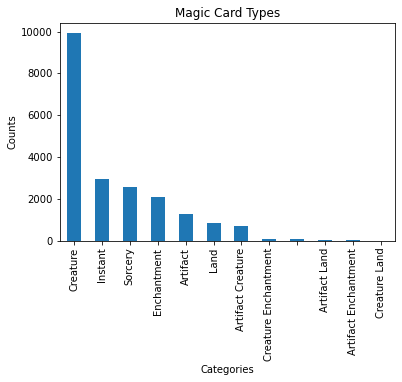

In [89]:
type_counts = data['card_type'].value_counts()
type_counts.plot(kind='bar')
plt.title('Magic Card Types')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.show()

Note that the above counts are for our curated list of cards with flavor text and not an exhaustive count of all cards in the game. Cards with multiple unique instances of flavor text are counted multiple times, and cards without flavor text are omitted.

AttributeError: 'list' object has no attribute 'join'